# Data Management

In [ ]:
%pip install seaborn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from pandas import read_csv
     

In [ ]:
!pip install rdflib 
import rdflib
!pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
import ssl

In [ ]:
!pip install sparql-dataframe
!pip install pyproj

import sparql_dataframe
import pandas as pd

from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.io import output_notebook, show
from bokeh.models import LogColorMapper, ColumnDataSource
from bokeh.palettes import Oranges256 as oranges

from pyproj import Proj, transform

### Setting the endpoint

In [ ]:
led_endpoint="http://data.open.ac.uk/sparql"

sparql_wd = SPARQLWrapper(led_endpoint)

### Data extraction and Cleansing

Retrieving the performances

In [106]:
query="""
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX edtf: <http://data.open.ac.uk/edtf/ontology/>
PREFIX edtfdata: <http://data.open.ac.uk/time/edtf/>
PREFIX event: <http://purl.org/NET/c4dm/event.owl#>
PREFIX led: <http://led.kmi.open.ac.uk/term/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
prefix mo:<http://purl.org/ontology/mo/>
SELECT DISTINCT   ?lexp  ?perflabel ?yoc
WHERE {
   ?lexp event:time [ rdfs:label ?when ; edtf:century edtfdata:Century.19 ; edtf:yearOfCentury/rdf:value ?yoc ].
   ?lexp  dc:subject ?perf.
   ?perf rdfs:label ?perflabel.
   ?perf mo:instrument ?instrument.
   ?instrument rdfs:label ?instrumentlabel.
   ?perf mo:genre ?genre.
   ?genre rdfs:label ?genrelabel.
   FILTER ( ?yoc >= 10 && ?yoc <= 25 ) 
}
"""

# use sparql dataframe to transform the SPARQL Json directly into a dataframe
df_perf = sparql_dataframe.get(led_endpoint, query, post=True)
df_perf

,lexp,perflabel,yoc
0,http://data.open.ac.uk/led/lexp/1436445995717,performance of 'Elektra',10
1,http://data.open.ac.uk/led/lexp/1463778051872,performance of 'Violin recital',25
2,http://data.open.ac.uk/led/lexp/1450111048055,performance of 'Bart��k's violin sonata',23
3,http://data.open.ac.uk/led/lexp/1434888849270,performance of 'Octuor',24
4,http://data.open.ac.uk/led/lexp/1434713465249,performance of 'Elgar Cello Concerto',24
...,...,...,...
301,http://data.open.ac.uk/led/lexp/1450295657640,performance of 'The Wedding',23
302,http://data.open.ac.uk/led/lexp/1481801646443,performance of 'Le Bouef sur le toit',20
303,http://data.open.ac.uk/led/lexp/1481801883076,performance of 'Le Bouef sur le toit',20
304,http://data.open.ac.uk/led/lexp/1481799874220,performance of ''Le Boeuf sur le toit'',20


In [108]:
df_perf['perflabel'].value_counts()

performance of 'Songs'                      6
performance of 'Piano Concerto'             6
performance of 'Les Biches'                 4
performance of 'The Crucifixion'            3
performance of 'Symphony no. 2'             3
                                           ..
performance of 'Second piano sonata'        1
performance of 'Tune from 'Matelots''       1
performance of 'Dvorak's Cello Concerto'    1
performance of 'Haydn Concerto in D'        1
performance of ''Le Boeuf sur le toit''     1
Name: perflabel, Length: 253, dtype: int64

retrieving instruments

In [34]:
query="""
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX edtf: <http://data.open.ac.uk/edtf/ontology/>
PREFIX edtfdata: <http://data.open.ac.uk/time/edtf/>
PREFIX event: <http://purl.org/NET/c4dm/event.owl#>
PREFIX led: <http://led.kmi.open.ac.uk/term/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
prefix mo:<http://purl.org/ontology/mo/>
SELECT DISTINCT   ?lexp  ?instrument ?yoc
WHERE {
   ?lexp event:time [ rdfs:label ?when ; edtf:century edtfdata:Century.19 ; edtf:yearOfCentury/rdf:value ?yoc ].
   ?lexp  dc:subject ?perf.
   ?perf rdfs:label ?perflabel.
   ?perf mo:instrument ?instrument.
   ?instrument rdfs:label ?instrumentlabel.
   ?perf mo:genre ?genre.
   ?genre rdfs:label ?genrelabel.
   FILTER ( ?yoc >= 10 && ?yoc <= 25 ) 
}
"""

# use sparql dataframe to transform the SPARQL Json directly into a dataframe
df_instr = sparql_dataframe.get(led_endpoint, query, post=True)
df_instr.head()

,lexp,instrument,yoc
0,http://data.open.ac.uk/led/lexp/1431987236952,http://dbpedia.org/resource/Orchestra,11
1,http://data.open.ac.uk/led/lexp/1431987236952,http://dbpedia.org/resource/Cello,11
2,http://data.open.ac.uk/led/lexp/1402484900240,http://dbpedia.org/resource/Harmonica,14
3,http://data.open.ac.uk/led/lexp/1432982795628,http://dbpedia.org/resource/Trombone,10
4,http://data.open.ac.uk/led/lexp/1432982795628,http://dbpedia.org/resource/Brass_instrument,10


### Extracting the labels

In [59]:
h=[]
for value in df_instr['instrument']:
  if "http://dbpedia.org/resource/" in value :
    new= str(value).replace("http://dbpedia.org/resource/", "")
    h.append(new)
  elif "https://data.open.ac.uk/led/thing/" in value:
    new= str(value).replace("https://data.open.ac.uk/led/thing/", "")
    h.append(new)
  elif "http://data.open.ac.uk/led/thing/" in value :
    new= str(value).replace("http://data.open.ac.uk/led/thing/", "")
    h.append(new)
  elif "http://data.open.ac.uk/led/" in value:
    new= str(value).replace("http://data.open.ac.uk/led/", "")
    h.append(new)
   
  elif "http://bnb.data.bl.uk/id/agent" in value :
    new= str(value).replace("http://bnb.data.bl.uk/id/agent", "")
    h.append(new)
  
  else:
    print(value)
    h.append(value)
instrument_label= pd.Series(h).astype(str)
df_instr['instrument_label']=instrument_label
df_instr

,lexp,instrument,yoc,instrument_label
0,http://data.open.ac.uk/led/lexp/1431987236952,http://dbpedia.org/resource/Orchestra,11,Orchestra
1,http://data.open.ac.uk/led/lexp/1431987236952,http://dbpedia.org/resource/Cello,11,Cello
2,http://data.open.ac.uk/led/lexp/1402484900240,http://dbpedia.org/resource/Harmonica,14,Harmonica
3,http://data.open.ac.uk/led/lexp/1432982795628,http://dbpedia.org/resource/Trombone,10,Trombone
4,http://data.open.ac.uk/led/lexp/1432982795628,http://dbpedia.org/resource/Brass_instrument,10,Brass_instrument
...,...,...,...,...
431,http://data.open.ac.uk/led/lexp/1464100756167,http://dbpedia.org/resource/Soprano,24,Soprano
432,http://data.open.ac.uk/led/lexp/1464304347332,http://dbpedia.org/resource/Symphony_orchestra,25,Symphony_orchestra
433,http://data.open.ac.uk/led/lexp/1464388311272,http://dbpedia.org/resource/Symphony_orchestra,25,Symphony_orchestra
434,http://data.open.ac.uk/led/lexp/1464100756167,http://dbpedia.org/resource/Symphony_orchestra,24,Symphony_orchestra


In [49]:
df_instr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   lexp              436 non-null    object
 1   instrument        436 non-null    object
 2   yoc               436 non-null    int64 
 3   instrument_label  436 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.8+ KB


### Absolute frequency of instruments

In [101]:
df_instr['instrument_label'].value_counts()

Piano                    77
Orchestra                57
Human_voice              47
Symphony_orchestra       34
Female_vocals            28
Violin                   26
Male_vocals              19
Soprano                  18
Choir                    15
Cello                    12
Military_band             9
Organ_(music)             9
Clarinet                  7
Tenor                     6
/Bass                     5
Trumpet                   5
Drum_kit                  4
Musical_ensemble          4
Trombone                  4
Contralto                 4
Double_bass               3
Jazz_band                 3
Mezzo-soprano             3
Cornet                    3
Brass_instrument          3
Percussion_instrument     2
Bagpipes                  2
Wind_instrument           2
Viola                     2
Harmonica                 2
String_instrument         2
Pump_organ                1
Player_piano              1
Fife_(instrument)         1
Regimental+band           1
massed+bands        

In [ ]:
instr_set=set()
for value in df_instr['instrument_label']:
    instr_set.add(value)
instr_set
#join together equal instruments

retrieving genres

In [50]:
query="""
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX edtf: <http://data.open.ac.uk/edtf/ontology/>
PREFIX edtfdata: <http://data.open.ac.uk/time/edtf/>
PREFIX event: <http://purl.org/NET/c4dm/event.owl#>
PREFIX led: <http://led.kmi.open.ac.uk/term/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
prefix mo:<http://purl.org/ontology/mo/>
SELECT DISTINCT   ?lexp  ?genre ?yoc
WHERE {
   ?lexp event:time [ rdfs:label ?when ; edtf:century edtfdata:Century.19 ; edtf:yearOfCentury/rdf:value ?yoc ].
   ?lexp  dc:subject ?perf.
   ?perf rdfs:label ?perflabel.
   ?perf mo:instrument ?instrument.
   ?instrument rdfs:label ?instrumentlabel.
   ?perf mo:genre ?genre.
   ?genre rdfs:label ?genrelabel.
   FILTER ( ?yoc >= 10 && ?yoc <= 25 ) 
}
"""

# use sparql dataframe to transform the SPARQL Json directly into a dataframe
df_genre = sparql_dataframe.get(led_endpoint, query, post=True)
df_genre.head()

,lexp,genre,yoc
0,http://data.open.ac.uk/led/lexp/1463778051872,http://dbpedia.org/resource/Classical_music,25
1,http://data.open.ac.uk/led/lexp/1464521657393,http://dbpedia.org/resource/Folk_music,25
2,http://data.open.ac.uk/led/lexp/1464041465931,http://dbpedia.org/resource/Piano_concerto,25
3,http://data.open.ac.uk/led/lexp/1464219122848,http://dbpedia.org/resource/20th-century_class...,25
4,http://data.open.ac.uk/led/lexp/1464085368509,http://dbpedia.org/resource/20th-century_class...,25


### Extracting the labels

In [80]:
h=[]
for value in df_genre['genre']:
  
  if "http://dbpedia.org/resource/" in value :
    new= str(value).replace("http://dbpedia.org/resource/", "")
    h.append(new)
  elif "https://data.open.ac.uk/led/thing/" in value:
    new= str(value).replace("https://data.open.ac.uk/led/thing/", "")
    h.append(new)
  elif "http://data.open.ac.uk/led/thing/" in value :
    new= str(value).replace("http://data.open.ac.uk/led/thing/", "")
    h.append(new)
  elif "http://data.open.ac.uk/led/musicgenre/" in value:
    new= str(value).replace("http://data.open.ac.uk/led/musicgenre/", "")
    h.append(new)
   
  
  
  else:
    print(value)
    
genre_label= pd.Series(h).astype(str)
df_genre['genre_label']=genre_label
df_genre

,lexp,genre,yoc,genre_label
0,http://data.open.ac.uk/led/lexp/1463778051872,http://dbpedia.org/resource/Classical_music,25,Classical_music
1,http://data.open.ac.uk/led/lexp/1464521657393,http://dbpedia.org/resource/Folk_music,25,Folk_music
2,http://data.open.ac.uk/led/lexp/1464041465931,http://dbpedia.org/resource/Piano_concerto,25,Piano_concerto
3,http://data.open.ac.uk/led/lexp/1464219122848,http://dbpedia.org/resource/20th-century_class...,25,20th-century_classical_music
4,http://data.open.ac.uk/led/lexp/1464085368509,http://dbpedia.org/resource/20th-century_class...,25,20th-century_classical_music
...,...,...,...,...
346,http://data.open.ac.uk/led/lexp/1464388311272,http://dbpedia.org/resource/Ballet_(music),25,Ballet_(music)
347,http://data.open.ac.uk/led/lexp/1464385241704,http://dbpedia.org/resource/Ballet_(music),25,Ballet_(music)
348,http://data.open.ac.uk/led/lexp/1464388710614,http://dbpedia.org/resource/Ballet_(music),25,Ballet_(music)
349,http://data.open.ac.uk/led/lexp/1460141219958,http://dbpedia.org/resource/Piano_solo,25,Piano_solo


In [77]:
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   lexp         351 non-null    object
 1   genre        351 non-null    object
 2   yoc          351 non-null    int64 
 3   genre_label  351 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.1+ KB


In [ ]:
genre_set=set()
for value in df_genre['genre_label']:
    genre_set.add(value)
for x in genre_set:
    print(x)
#traditional+song, traditional+song, Traditional_music should be the same
#violin_concerto , violin+repertoire


### Absolute frequency of genres

In [102]:
df_genre['genre_label'].value_counts()

20th-century_classical_music    63
Classical_music                 47
Ballet_(music)                  29
Opera                           26
Song                            16
                                ..
Anthem                           1
choral+ballad                    1
Music_of_Wales                   1
Coronation+anthem                1
Humouresque                      1
Name: genre_label, Length: 64, dtype: int64


## Sentiment analysis with [Scikit-learn](https://scikit-learn.org/stable/):

We could analyse sentiments over time! - by adding the year in the selected variables


- training dataset: https://www.kaggle.com/datasets/parulpandey/emotion-dataset?select=validation.csv 

  provides a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5). 


In [22]:

import pandas as pd
train = pd.read_csv('Data/training.csv')

#labelling feelings
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['description'] = train['label'].map(labels_dict )


X = train['text'] 
y = train['description']

from numpy import random,array

random.seed(0)

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer(ngram_range=(1,2)) 
X=vect.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)


from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()

model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

#errori = accuracy_score(y_test, p_test)
#print(errori)

#How to analyze a single query:
q=array(['good wonderful film']) 
q=vect.transform(q)

print(model.predict(q))

z=array(['horrible sad bad fiml']) 
z=vect.transform(z)
print(model.predict(z))

['joy']
['sadness']


In [24]:
led_endpoint="http://data.open.ac.uk/sparql"

sparql_wd = SPARQLWrapper(led_endpoint)

In [53]:
## CQ11 What did people ‘make of’, how did they react to, e.g. music

#retrieve texts for doing sentiment analysis
query = """
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX edtf: <http://data.open.ac.uk/edtf/ontology/>
PREFIX edtfdata: <http://data.open.ac.uk/time/edtf/>
PREFIX event: <http://purl.org/NET/c4dm/event.owl#>
PREFIX led: <http://led.kmi.open.ac.uk/term/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
prefix mo:<http://purl.org/ontology/mo/>
prefix db:<http://dbpedia.org/ontology/>
prefix uk:<http://data.open.ac.uk/ukresearchproject/ontology/>
prefix ox:<http://vocab.ox.ac.uk/projectfunding#>
  
SELECT DISTINCT ?lexp  ?text  ?description ?when ?yoc
WHERE { 
  ?lexp event:time [ rdfs:label ?when ; edtf:century edtfdata:Century.19 ; edtf:yearOfCentury/rdf:value ?yoc ].
  
  ?lexp  dc:subject ?perf.
  ?perf mo:performance_of ?song.
  ?song rdfs:label ?songlabel.
  ?lexp led:has_evidence_text ?text.
  FILTER ( ?yoc >= 10 && ?yoc <= 25) 
}
"""
# set the query
sparql_wd.setQuery(query)
# set the returned format
sparql_wd.setReturnFormat(JSON)
# get the results
results = sparql_wd.query().convert()
import pandas as pds
df_text = pds.DataFrame(results['results']['bindings'])
df_text.applymap(lambda x: x['value']) #drop the duplicates! maybe selecting the perf uri instead of songlabel


,lexp,text,when,yoc
0,http://data.open.ac.uk/led/lexp/1402915111602,Arrive at Bombay at 6.00 am. Detrain at 9.00 a...,"6 April, 1919, 03:00 PM",19
1,http://data.open.ac.uk/led/lexp/1393862273536,Sept 10th We have all been to an entertainment...,"10 September, 1915",15
2,http://data.open.ac.uk/led/lexp/1399978894531,It is Sunday evening and someone next door has...,"18 October, 1914",14
3,http://data.open.ac.uk/led/lexp/1435573801974,Sunday Feb. 13. Discovered the Morels in a new...,"13 February, 1916",16
4,http://data.open.ac.uk/led/lexp/1430310734878,"In the end I did go down, but only to shut him...",1924,24
...,...,...,...,...
178,http://data.open.ac.uk/led/lexp/1397646195500,The funeral [of VAD nurse Arnold] was held at ...,"15 March, 1916, 02:00 PM",16
179,http://data.open.ac.uk/led/lexp/1393865786318,Peace broke out when I was at Gallipoli.\tI wi...,at the end of 1918,18
180,http://data.open.ac.uk/led/lexp/1395329925159,"We came away for a couple of nights, and were ...","November, 1916",16
181,http://data.open.ac.uk/led/lexp/1408022855779,...[Having been wounded] I became attached to ...,"early , month unknown, 1917",17


In [54]:
df_sent = pd.DataFrame(columns=['lexp','text','sentiment','year'])


idx=0
for result in results["results"]["bindings"]:
    
    q =array([result["text"]["value"]])
    q=vect.transform(q)
    sent=str(model.predict(q)).replace("[","").replace("]","")
    df_sent.loc[idx] = [str(result['lexp']['value']),str(result["text"]["value"]),str(sent),int(result["yoc"]["value"])]
    idx+=1

df_sent

,lexp,text,sentiment,year
0,http://data.open.ac.uk/led/lexp/1402915111602,Arrive at Bombay at 6.00 am. Detrain at 9.00 a...,'sadness',19
1,http://data.open.ac.uk/led/lexp/1393862273536,Sept 10th We have all been to an entertainment...,'joy',15
2,http://data.open.ac.uk/led/lexp/1399978894531,It is Sunday evening and someone next door has...,'sadness',14
3,http://data.open.ac.uk/led/lexp/1435573801974,Sunday Feb. 13. Discovered the Morels in a new...,'joy',16
4,http://data.open.ac.uk/led/lexp/1430310734878,"In the end I did go down, but only to shut him...",'anger',24
...,...,...,...,...
178,http://data.open.ac.uk/led/lexp/1397646195500,The funeral [of VAD nurse Arnold] was held at ...,'sadness',16
179,http://data.open.ac.uk/led/lexp/1393865786318,Peace broke out when I was at Gallipoli.\tI wi...,'fear',18
180,http://data.open.ac.uk/led/lexp/1395329925159,"We came away for a couple of nights, and were ...",'joy',16
181,http://data.open.ac.uk/led/lexp/1408022855779,...[Having been wounded] I became attached to ...,'joy',17


In [103]:
df_sent['sentiment'].value_counts()

'joy'         126
'sadness'      16
'love'         15
'anger'        14
'fear'          9
'surprise'      3
Name: sentiment, dtype: int64

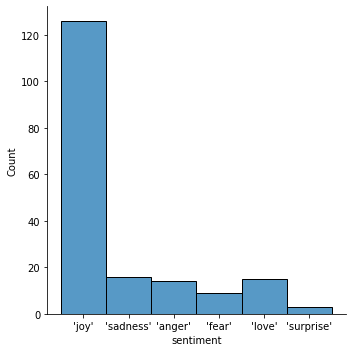

In [28]:
sns.displot(data=df_sent, x='sentiment')

# Exploring and Visualizing

C:\Users\lored\AppData\Local\Temp\ipykernel_38244\1306901389.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['yoc'], kde=False);


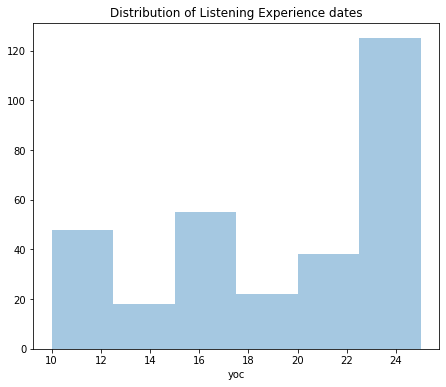

In [86]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(df['yoc'], kde=False);
plt.title('Distribution of Listening Experience dates');

Visualizing sentiments over time:

In [122]:
# reset_index() gives a column for counting, after groupby uses year and category
ctdf = (df_sent.reset_index()
          .groupby(['year','sentiment'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

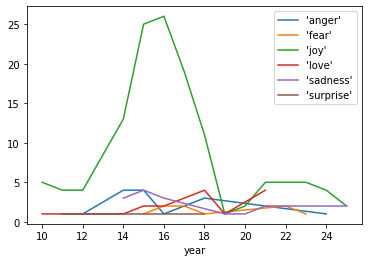

In [123]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

# key gives the group name (i.e. category), data gives the actual values
for key, data in ctdf.groupby('sentiment'):
    data.plot(x='year', y='ct', ax=ax, label=key)